[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb)

# Antonyms


 The notebook tries to find a circuit for antonyms.

## Tips for Reading This

* If running in Google Colab, go to Runtime > Change Runtime Type and select GPU as the hardware
accelerator.
* Look up unfamiliar terms in [the mech interp explainer](https://neelnanda.io/glossary)
* You can run all this code for yourself
* The graphs are interactive
* Use the table of contents pane in the sidebar to navigate (in Colab) or VSCode's "Outline" in the
  explorer tab.
* Collapse irrelevant sections with the dropdown arrows
* Search the page using the search in the sidebar (with Colab) not CTRL+F

## Setup

### Environment Setup (ignore)

**You can ignore this part:** It's just for use internally to setup the tutorial in different
environments. You can delete this section if using in your own repo.

In [2]:

# Detect if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    # Install a faster Node version
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

# Hot reload in development mode & not running on the CD
if not IN_COLAB:
    from IPython import get_ipython
    ip = get_ipython()
    if not ip.extension_manager.loaded:
        ip.extension_manager.load('autoreload')
        %autoreload 2


### Imports

In [3]:
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

/Users/alokbeniwal/nanda-mech-interp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PyTorch Setup

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


### Plotting Helper Functions (ignore)

Some plotting helper functions are included here (for simplicity).

In [5]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

## Introduction

The capability we're trying to reverse engineer is the ability to find antonyms. An antonym is a word that is opposite in meaning to another word. For example, "hot" and "cold" are antonyms, as are "up" and "down".



### Indirect Object Identification

The first step when trying to reverse engineer a circuit in a model is to identify *what* capability
I want to reverse engineer. Indirect Object Identification is a task studied in Redwood Research's
excellent [Interpretability in the Wild](https://arxiv.org/abs/2211.00593) paper (see [my interview
with the authors](https://www.youtube.com/watch?v=gzwj0jWbvbo) or [Kevin Wang's Twitter
thread](https://threadreaderapp.com/thread/1587601532639494146.html) for an overview). The task is
to complete sentences like "After John and Mary went to the shops, John gave a bottle of milk to"
with " Mary" rather than " John".

In the paper they rigorously reverse engineer a 26 head circuit, with 7 separate categories of heads
used to perform this capability. Their rigorous methods are fairly involved, so in this notebook,
I'm going to skimp on rigour and instead try to speed run the process of finding suggestive evidence
for this circuit!

The circuit they found roughly breaks down into three parts:
1. Identify what names are in the sentence
2. Identify which names are duplicated
3. Predict the name that is *not* duplicated

The first step is to load in our model. I use GPT-Neo-2.7B because it ran fast enough and got clearer improvements over GPT-2 Small, but Small works pretty well too and Quinn used it.

In [6]:
MODEL_NAME = "EleutherAI/gpt-neo-2.7B"
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)
# add left padding
model.tokenizer.padding_side = "left"
model.set_tokenizer(default_padding_side="left", tokenizer=model.tokenizer)
# Get the default device used
device: torch.device = utils.get_device()

Loaded pretrained model EleutherAI/gpt-neo-2.7B into HookedTransformer


## Verifying model can do task

Alok: found that Neo doesn't seem to get syntax/semantics, but otherwise seems to understand opposition. 

See the graphs for evidence that they can do it


In [7]:
from typing import NamedTuple

from regex import D
from sympy import PermutationMatrix


def unzip(tuples):
    return zip(*tuples)


class Answer(NamedTuple):
    correct: str
    incorrect: str

In [8]:
def get_answer_tokens(
    answers: list[Answer], model=model, corrupted: bool = False
) -> Float[torch.Tensor, "batch 2"]:
    """HACK: returns the tokens for the correct and incorrect answers, in that order.
    If `corrupted` is True, then the correct and incorrect answers are swapped."""
    return torch.tensor(
        [
            (
                model.to_single_token(a.incorrect if corrupted else a.correct),
                model.to_single_token(a.correct if corrupted else a.incorrect),
            )
            for a in answers
        ],
        device=device,
    )

In [9]:
prompts_and_answers: list[tuple[str, Answer]] = [
    ("\n\nInstead of turning left, the character turned", Answer(" right", " left")),
    ("\nThe bird did not fly up, it flew", Answer(" down", " up")),
    ("\n\nThe data is not discrete, it is", Answer(" continuous", " discrete")),
    ("She did not walk towards the right, she moved to the", Answer(" left", " right")),
    ("He did not walk towards the left, he moved to the", Answer(" right", " left")),
    ("\n\nThe data is not continuous, it is", Answer(" discrete", " continuous")),
    ("\nTo avoid going down, the climber went", Answer(" up", " down")),
    ("\nTo avoid going up, the climber went", Answer(" down", " up")),
    ("The vehicle couldn't turn left, so it turned", Answer(" right", " left")),
    ("The vehicle couldn't turn right, so it turned", Answer(" left", " right")),
    # ("syntax is dual to", Answer(" semantics", " syntax")),
    # TODO(alok): HACK. it gets the previous one, maybe bc 'syntax and semantics' is a set phrase but 'semantics and syntax' isn't
    # ("semantics is dual to", Answer(" syntax", " semantics")),
    ("he feels hot, but i feel", Answer(" cold", " hot")),
    ("\nThe sun did not rise in the east, it rose in the", Answer(" west", " east")),
    (
        "\n\nThe player did not pass the ball forward, they passed it",
        Answer(" backward", " forward"),
    ),
    # ("\n The water did not freeze, it", Answer(" boiled", " froze")),
    ("\n\nThe door didn't open inward, it swung", Answer(" outward", " inward")),
    # ("\nInstead of accepting the offer, she", Answer(" rejected", " accepted")),  # does poorly here, maybe too open ended?
]


prompts, answers = unzip(prompts_and_answers)
print(prompts, answers)
prompt_tokens = [model.to_tokens(prompt) for prompt in prompts]
answer_tokens = get_answer_tokens(answers)

('\n\nInstead of turning left, the character turned', '\nThe bird did not fly up, it flew', '\n\nThe data is not discrete, it is', 'She did not walk towards the right, she moved to the', 'He did not walk towards the left, he moved to the', '\n\nThe data is not continuous, it is', '\nTo avoid going down, the climber went', '\nTo avoid going up, the climber went', "The vehicle couldn't turn left, so it turned", "The vehicle couldn't turn right, so it turned", 'he feels hot, but i feel', '\nThe sun did not rise in the east, it rose in the', '\n\nThe player did not pass the ball forward, they passed it', "\n\nThe door didn't open inward, it swung") (Answer(correct=' right', incorrect=' left'), Answer(correct=' down', incorrect=' up'), Answer(correct=' continuous', incorrect=' discrete'), Answer(correct=' left', incorrect=' right'), Answer(correct=' right', incorrect=' left'), Answer(correct=' discrete', incorrect=' continuous'), Answer(correct=' up', incorrect=' down'), Answer(correct=' do

**Gotcha**: It's important that all of your prompts have the same number of tokens. If they're different lengths, then the position of the "final" logit where you can check logit difference will differ between prompts, and this will break the below code. The easiest solution is just to choose your prompts carefully to have the same number of tokens (you can eg add filler words like The, or newlines to start).

I fix this by left padding with newlines

In [10]:
def leftpad(strs: list[str], model, pad_char: str = "\n") -> list[str]:
    """Left pads each string in the list to the length of the longest string."""
    lens = [len(model.to_str_tokens(s)) for s in strs]
    maxlen = max(lens)
    out = [pad_char * (maxlen - len(model.to_str_tokens(s))) + s for s in strs]

    # TODO(alok): HACK sometimes the tokenizer merges newlines and adding a newline doesn't increase token count, so run until everything is same tokenized length.
    while len(set(lens)) > 1:
        out = leftpad(out, model)
        lens = [len(model.to_str_tokens(s)) for s in out]
    return out

We now run the model on these prompts and use `run_with_cache` to get both the logits and a cache of all internal activations for later analysis

In [11]:
tokens = model.to_tokens(leftpad(prompts, model), prepend_bos=True)
original_logits: Float[torch.Tensor, "batch tokens vocab"]
# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

We'll later be evaluating how model performance differs upon performing various interventions, so it's useful to have a metric to measure model performance. Our metric here will be the **logit difference**, the difference in logit between the indirect object's name and the subject's name (eg, `logit(Mary)-logit(John)`).

Alok: my first metric will be the difference between the logits between a word and its opposite. For more robustness, we could compare to a set of opposing words and take some average.

In [12]:
def logits_to_avg_logit_diff(
    logits: Float[torch.Tensor, "batch tokens vocab"],
    answer_tokens: Float[torch.Tensor, "batch 2"],
    per_prompt=False,
):
    # Only the final logits are relevant for the answer
    final_logits: Float[torch.Tensor, "batch vocab"] = logits[:, -1, :]

    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    correct_logits, incorrect_logits = answer_logits[:, 0], answer_logits[:, 1]
    answer_logit_diff = correct_logits - incorrect_logits
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

Per prompt logit difference: tensor([ 2.1070,  1.7540,  3.3410,  2.6260,  2.8600,  3.2700, -0.4260,  2.2520,
         3.1950,  2.4530,  2.6580,  4.1310,  1.6190,  0.7020])
Average logit difference: 2.324
Prompt: Instead of turning left, the character turned                          Answer:  right          Logit Difference: 2.11
Prompt: The bird did not fly up, it flew                                       Answer:  down           Logit Difference: 1.75
Prompt: The data is not discrete, it is                                        Answer:  continuous     Logit Difference: 3.34
Prompt: She did not walk towards the right, she moved to the                   Answer:  left           Logit Difference: 2.63
Prompt: He did not walk towards the left, he moved to the                      Answer:  right          Logit Difference: 2.86
Prompt: The data is not continuous, it is                                      Answer:  discrete       Logit Difference: 3.27
Prompt: To avoid going down, the climber

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Scatter Plot of Logit Differences for EleutherAI/gpt-neo-2.7B - Average Difference: 2.32')

Text(0.5, 0, 'Prompt Index')

Text(0, 0.5, 'Logit Difference')

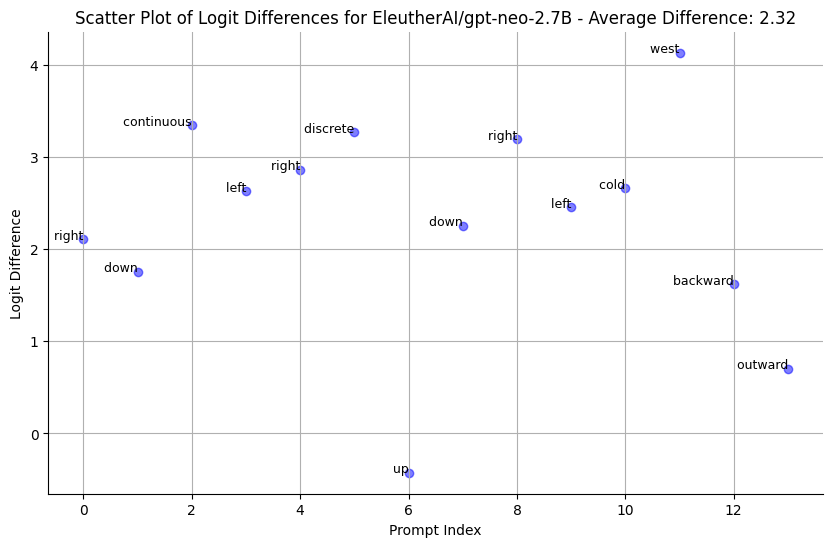

In [29]:
print(
    "Per prompt logit difference:",
    logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
orig_average_logit_diff = logits_to_avg_logit_diff(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(orig_average_logit_diff.item(), 3),
)


# Display prompts, answers, and logits in a side-by-side format with constant spacing
logit_diffs = logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
for prompt, answer, logit_diff in zip(prompts, answers, logit_diffs):
    print(
        f"Prompt: {prompt.strip():<70} Answer: {answer.correct:<15} Logit Difference: {logit_diff.item():.2f}"
    )


# Calculate logit differences for each prompt
logit_diffs = (
    logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .numpy()
)
# Generate a scatter plot of the logit differences with labels for each point
plt.figure(figsize=(10, 6))
for i, (logit_diff, answer) in enumerate(zip(logit_diffs, answers)):
    _ = plt.scatter(i, logit_diff, color="blue", alpha=0.5)
    _ = plt.text(i, logit_diff, f"{answer.correct}", fontsize=9, ha="right")

# Calculate the average logit difference for the title
average_logit_diff = np.mean(logit_diffs)
plt.title(
    f"Scatter Plot of Logit Differences for {MODEL_NAME} - Average Difference: {average_logit_diff:.2f}"
)
plt.xlabel("Prompt Index")
plt.ylabel("Logit Difference")
plt.grid(True)
plt.show()

In [14]:
for prompt, answer in zip(prompts, answers):
    print(utils.test_prompt(prompt, answer.correct, model, prepend_bos=True))

Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'Instead', ' of', ' turning', ' left', ',', ' the', ' character', ' turned']
Tokenized answer: [' right']


Performance on answer token:
Rank: 0        Logit: 17.93 Prob: 61.74% Token: | right|

Top 0th token. Logit: 17.93 Prob: 61.74% Token: | right|
Top 1th token. Logit: 15.94 Prob:  8.49% Token: | left|
Top 2th token. Logit: 15.62 Prob:  6.13% Token: | to|
Top 3th token. Logit: 14.81 Prob:  2.73% Token: | into|
Top 4th token. Logit: 14.54 Prob:  2.08% Token: | the|
Top 5th token. Logit: 14.40 Prob:  1.82% Token: | down|
Top 6th token. Logit: 14.18 Prob:  1.46% Token: | around|
Top 7th token. Logit: 14.11 Prob:  1.36% Token: | up|
Top 8th token. Logit: 13.81 Prob:  1.00% Token: | back|
Top 9th token. Logit: 13.64 Prob:  0.85% Token: | straight|


Ranks of the answer tokens: [(' right', 0)]

TestPromptOutput(correct_rank=0, logit=17.929218292236328, prob=0.617433488368988, answer=' right', answer_str_token=' right')
Tokenized prompt: ['<|endoftext|>', '\n', 'The', ' bird', ' did', ' not', ' fly', ' up', ',', ' it', ' flew']
Tokenized answer: [' down']


Performance on answer token:
Rank: 0        Logit: 17.72 Prob: 43.88% Token: | down|

Top 0th token. Logit: 17.72 Prob: 43.88% Token: | down|
Top 1th token. Logit: 16.15 Prob:  9.09% Token: | up|
Top 2th token. Logit: 15.50 Prob:  4.75% Token: | straight|
Top 3th token. Logit: 15.16 Prob:  3.38% Token: | into|
Top 4th token. Logit: 14.99 Prob:  2.86% Token: | back|
Top 5th token. Logit: 14.97 Prob:  2.80% Token: | away|
Top 6th token. Logit: 14.82 Prob:  2.41% Token: | in|
Top 7th token. Logit: 14.74 Prob:  2.21% Token: | to|
Top 8th token. Logit: 14.63 Prob:  2.00% Token: | out|
Top 9th token. Logit: 14.41 Prob:  1.60% Token: | right|


Ranks of the answer tokens: [(' down', 0)]

TestPromptOutput(correct_rank=0, logit=17.72306251525879, prob=0.4388437867164612, answer=' down', answer_str_token=' down')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' data', ' is', ' not', ' discrete', ',', ' it', ' is']
Tokenized answer: [' continuous']


Performance on answer token:
Rank: 0        Logit: 15.44 Prob: 33.67% Token: | continuous|

Top 0th token. Logit: 15.44 Prob: 33.67% Token: | continuous|
Top 1th token. Logit: 14.43 Prob: 12.30% Token: | a|
Top 2th token. Logit: 13.59 Prob:  5.31% Token: | not|
Top 3th token. Logit: 12.61 Prob:  1.99% Token: | an|
Top 4th token. Logit: 12.44 Prob:  1.68% Token: | in|
Top 5th token. Logit: 12.08 Prob:  1.18% Token: | the|
Top 6th token. Logit: 11.96 Prob:  1.04% Token: | distributed|
Top 7th token. Logit: 11.90 Prob:  0.98% Token: | continuously|
Top 8th token. Logit: 11.84 Prob:  0.92% Token: | discrete|
Top 9th token. Logit: 11.65 Prob:  0.76% Token: | spread|


Ranks of the answer tokens: [(' continuous', 0)]

TestPromptOutput(correct_rank=0, logit=15.43745231628418, prob=0.33673566579818726, answer=' continuous', answer_str_token=' continuous')
Tokenized prompt: ['<|endoftext|>', 'She', ' did', ' not', ' walk', ' towards', ' the', ' right', ',', ' she', ' moved', ' to', ' the']
Tokenized answer: [' left']


Performance on answer token:
Rank: 0        Logit: 17.57 Prob: 79.57% Token: | left|

Top 0th token. Logit: 17.57 Prob: 79.57% Token: | left|
Top 1th token. Logit: 15.53 Prob: 10.40% Token: | right|
Top 2th token. Logit: 13.60 Prob:  1.50% Token: | middle|
Top 3th token. Logit: 12.99 Prob:  0.81% Token: | centre|
Top 4th token. Logit: 12.91 Prob:  0.76% Token: | side|
Top 5th token. Logit: 12.62 Prob:  0.56% Token: | center|
Top 6th token. Logit: 12.26 Prob:  0.40% Token: | other|
Top 7th token. Logit: 12.18 Prob:  0.36% Token: | far|
Top 8th token. Logit: 12.03 Prob:  0.31% Token: | front|
Top 9th token. Logit: 11.75 Prob:  0.24% Token: | very|


Ranks of the answer tokens: [(' left', 0)]

TestPromptOutput(correct_rank=0, logit=17.568321228027344, prob=0.7956908345222473, answer=' left', answer_str_token=' left')
Tokenized prompt: ['<|endoftext|>', 'He', ' did', ' not', ' walk', ' towards', ' the', ' left', ',', ' he', ' moved', ' to', ' the']
Tokenized answer: [' right']


Performance on answer token:
Rank: 0        Logit: 17.00 Prob: 72.94% Token: | right|

Top 0th token. Logit: 17.00 Prob: 72.94% Token: | right|
Top 1th token. Logit: 14.83 Prob:  8.33% Token: | left|
Top 2th token. Logit: 13.83 Prob:  3.09% Token: | centre|
Top 3th token. Logit: 13.71 Prob:  2.73% Token: | middle|
Top 4th token. Logit: 13.13 Prob:  1.53% Token: | center|
Top 5th token. Logit: 12.88 Prob:  1.19% Token: | other|
Top 6th token. Logit: 12.75 Prob:  1.05% Token: | far|
Top 7th token. Logit: 12.05 Prob:  0.52% Token: | extreme|
Top 8th token. Logit: 12.05 Prob:  0.52% Token: | side|
Top 9th token. Logit: 11.91 Prob:  0.45% Token: | very|


Ranks of the answer tokens: [(' right', 0)]

TestPromptOutput(correct_rank=0, logit=16.99580955505371, prob=0.7294237613677979, answer=' right', answer_str_token=' right')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' data', ' is', ' not', ' continuous', ',', ' it', ' is']
Tokenized answer: [' discrete']


Performance on answer token:
Rank: 1        Logit: 13.91 Prob:  8.18% Token: | discrete|

Top 0th token. Logit: 14.48 Prob: 14.50% Token: | a|
Top 1th token. Logit: 13.91 Prob:  8.18% Token: | discrete|
Top 2th token. Logit: 13.49 Prob:  5.37% Token: | not|
Top 3th token. Logit: 12.56 Prob:  2.13% Token: | sampled|
Top 4th token. Logit: 12.41 Prob:  1.82% Token: | only|
Top 5th token. Logit: 12.39 Prob:  1.80% Token: | an|
Top 6th token. Logit: 12.27 Prob:  1.59% Token: | in|
Top 7th token. Logit: 12.16 Prob:  1.42% Token: | categ|
Top 8th token. Logit: 12.06 Prob:  1.29% Token: | binary|
Top 9th token. Logit: 12.03 Prob:  1.25% Token: | missing|


Ranks of the answer tokens: [(' discrete', 1)]

TestPromptOutput(correct_rank=1, logit=13.908510208129883, prob=0.08183404058218002, answer=' discrete', answer_str_token=' discrete')
Tokenized prompt: ['<|endoftext|>', '\n', 'To', ' avoid', ' going', ' down', ',', ' the', ' clim', 'ber', ' went']
Tokenized answer: [' up']


Performance on answer token:
Rank: 0        Logit: 16.98 Prob: 18.76% Token: | up|

Top 0th token. Logit: 16.98 Prob: 18.76% Token: | up|
Top 1th token. Logit: 16.78 Prob: 15.38% Token: | down|
Top 2th token. Logit: 16.52 Prob: 11.91% Token: | to|
Top 3th token. Logit: 16.15 Prob:  8.23% Token: | back|
Top 4th token. Logit: 15.43 Prob:  3.97% Token: | around|
Top 5th token. Logit: 15.35 Prob:  3.68% Token: | on|
Top 6th token. Logit: 15.29 Prob:  3.49% Token: | over|
Top 7th token. Logit: 15.11 Prob:  2.91% Token: | straight|
Top 8th token. Logit: 14.84 Prob:  2.22% Token: | into|
Top 9th token. Logit: 14.56 Prob:  1.67% Token: | through|


Ranks of the answer tokens: [(' up', 0)]

TestPromptOutput(correct_rank=0, logit=16.977611541748047, prob=0.18761871755123138, answer=' up', answer_str_token=' up')
Tokenized prompt: ['<|endoftext|>', '\n', 'To', ' avoid', ' going', ' up', ',', ' the', ' clim', 'ber', ' went']
Tokenized answer: [' down']


Performance on answer token:
Rank: 0        Logit: 18.28 Prob: 48.11% Token: | down|

Top 0th token. Logit: 18.28 Prob: 48.11% Token: | down|
Top 1th token. Logit: 16.60 Prob:  8.97% Token: | back|
Top 2th token. Logit: 16.22 Prob:  6.12% Token: | to|
Top 3th token. Logit: 15.91 Prob:  4.51% Token: | up|
Top 4th token. Logit: 15.85 Prob:  4.23% Token: | around|
Top 5th token. Logit: 15.29 Prob:  2.42% Token: | left|
Top 6th token. Logit: 15.19 Prob:  2.18% Token: | over|
Top 7th token. Logit: 15.06 Prob:  1.92% Token: | straight|
Top 8th token. Logit: 14.96 Prob:  1.73% Token: | right|
Top 9th token. Logit: 14.58 Prob:  1.19% Token: | on|


Ranks of the answer tokens: [(' down', 0)]

TestPromptOutput(correct_rank=0, logit=18.280973434448242, prob=0.4810919463634491, answer=' down', answer_str_token=' down')
Tokenized prompt: ['<|endoftext|>', 'The', ' vehicle', ' couldn', "'t", ' turn', ' left', ',', ' so', ' it', ' turned']
Tokenized answer: [' right']


Performance on answer token:
Rank: 0        Logit: 18.46 Prob: 63.76% Token: | right|

Top 0th token. Logit: 18.46 Prob: 63.76% Token: | right|
Top 1th token. Logit: 15.99 Prob:  5.38% Token: | into|
Top 2th token. Logit: 15.66 Prob:  3.88% Token: | to|
Top 3th token. Logit: 15.40 Prob:  2.99% Token: | around|
Top 4th token. Logit: 15.00 Prob:  2.00% Token: | left|
Top 5th token. Logit: 14.96 Prob:  1.93% Token: | straight|
Top 6th token. Logit: 14.87 Prob:  1.75% Token: | back|
Top 7th token. Logit: 14.75 Prob:  1.55% Token: | in|
Top 8th token. Logit: 14.52 Prob:  1.23% Token: | out|
Top 9th token. Logit: 14.20 Prob:  0.90% Token: | on|


Ranks of the answer tokens: [(' right', 0)]

TestPromptOutput(correct_rank=0, logit=18.463138580322266, prob=0.6376103758811951, answer=' right', answer_str_token=' right')
Tokenized prompt: ['<|endoftext|>', 'The', ' vehicle', ' couldn', "'t", ' turn', ' right', ',', ' so', ' it', ' turned']
Tokenized answer: [' left']


Performance on answer token:
Rank: 0        Logit: 18.55 Prob: 61.63% Token: | left|

Top 0th token. Logit: 18.55 Prob: 61.63% Token: | left|
Top 1th token. Logit: 16.02 Prob:  4.88% Token: | right|
Top 2th token. Logit: 15.88 Prob:  4.27% Token: | into|
Top 3th token. Logit: 15.57 Prob:  3.11% Token: | to|
Top 4th token. Logit: 15.51 Prob:  2.92% Token: | around|
Top 5th token. Logit: 15.02 Prob:  1.80% Token: | in|
Top 6th token. Logit: 14.99 Prob:  1.74% Token: | out|
Top 7th token. Logit: 14.90 Prob:  1.60% Token: | back|
Top 8th token. Logit: 14.55 Prob:  1.12% Token: | on|
Top 9th token. Logit: 14.45 Prob:  1.02% Token: | straight|


Ranks of the answer tokens: [(' left', 0)]

TestPromptOutput(correct_rank=0, logit=18.55448341369629, prob=0.6162826418876648, answer=' left', answer_str_token=' left')
Tokenized prompt: ['<|endoftext|>', 'he', ' feels', ' hot', ',', ' but', ' i', ' feel']
Tokenized answer: [' cold']


Performance on answer token:
Rank: 0        Logit: 15.55 Prob: 21.66% Token: | cold|

Top 0th token. Logit: 15.55 Prob: 21.66% Token: | cold|
Top 1th token. Logit: 14.98 Prob: 12.30% Token: | like|
Top 2th token. Logit: 13.97 Prob:  4.44% Token: | cool|
Top 3th token. Logit: 13.46 Prob:  2.69% Token: | a|
Top 4th token. Logit: 13.44 Prob:  2.64% Token: | no|
Top 5th token. Logit: 13.27 Prob:  2.21% Token: | good|
Top 6th token. Logit: 13.22 Prob:  2.12% Token: | nothing|
Top 7th token. Logit: 13.22 Prob:  2.10% Token: | hot|
Top 8th token. Logit: 13.21 Prob:  2.08% Token: | fine|
Top 9th token. Logit: 13.08 Prob:  1.83% Token: | so|


Ranks of the answer tokens: [(' cold', 0)]

TestPromptOutput(correct_rank=0, logit=15.549994468688965, prob=0.21660231053829193, answer=' cold', answer_str_token=' cold')
Tokenized prompt: ['<|endoftext|>', '\n', 'The', ' sun', ' did', ' not', ' rise', ' in', ' the', ' east', ',', ' it', ' rose', ' in', ' the']
Tokenized answer: [' west']


Performance on answer token:
Rank: 0        Logit: 17.19 Prob: 82.47% Token: | west|

Top 0th token. Logit: 17.19 Prob: 82.47% Token: | west|
Top 1th token. Logit: 13.94 Prob:  3.19% Token: | West|
Top 2th token. Logit: 13.62 Prob:  2.30% Token: | north|
Top 3th token. Logit: 13.56 Prob:  2.17% Token: | south|
Top 4th token. Logit: 13.06 Prob:  1.33% Token: | east|
Top 5th token. Logit: 12.59 Prob:  0.82% Token: | sky|
Top 6th token. Logit: 11.95 Prob:  0.43% Token: | middle|
Top 7th token. Logit: 11.94 Prob:  0.43% Token: | western|
Top 8th token. Logit: 11.77 Prob:  0.36% Token: |
|
Top 9th token. Logit: 11.07 Prob:  0.18% Token: | southwest|


Ranks of the answer tokens: [(' west', 0)]

TestPromptOutput(correct_rank=0, logit=17.194602966308594, prob=0.8247151970863342, answer=' west', answer_str_token=' west')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' player', ' did', ' not', ' pass', ' the', ' ball', ' forward', ',', ' they', ' passed', ' it']
Tokenized answer: [' backward']


Performance on answer token:
Rank: 1        Logit: 16.42 Prob: 11.43% Token: | backward|

Top 0th token. Logit: 17.42 Prob: 31.32% Token: | backwards|
Top 1th token. Logit: 16.42 Prob: 11.43% Token: | backward|
Top 2th token. Logit: 16.39 Prob: 11.17% Token: | back|
Top 3th token. Logit: 16.38 Prob: 11.02% Token: | to|
Top 4th token. Logit: 16.02 Prob:  7.65% Token: | sideways|
Top 5th token. Logit: 14.80 Prob:  2.26% Token: | forward|
Top 6th token. Logit: 14.26 Prob:  1.33% Token: | on|
Top 7th token. Logit: 14.14 Prob:  1.17% Token: | in|
Top 8th token. Logit: 14.00 Prob:  1.02% Token: | out|
Top 9th token. Logit: 13.99 Prob:  1.01% Token: | around|


Ranks of the answer tokens: [(' backward', 1)]

TestPromptOutput(correct_rank=1, logit=16.416166305541992, prob=0.1142755001783371, answer=' backward', answer_str_token=' backward')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' door', ' didn', "'t", ' open', ' inward', ',', ' it', ' swung']
Tokenized answer: [' outward']


Performance on answer token:
Rank: 1        Logit: 17.75 Prob: 11.58% Token: | outward|

Top 0th token. Logit: 18.97 Prob: 38.92% Token: | open|
Top 1th token. Logit: 17.75 Prob: 11.58% Token: | outward|
Top 2th token. Logit: 17.51 Prob:  9.06% Token: | out|
Top 3th token. Logit: 17.40 Prob:  8.09% Token: | inward|
Top 4th token. Logit: 17.17 Prob:  6.45% Token: | wide|
Top 5th token. Logit: 16.93 Prob:  5.06% Token: | in|
Top 6th token. Logit: 16.29 Prob:  2.69% Token: | back|
Top 7th token. Logit: 15.58 Prob:  1.32% Token: | to|
Top 8th token. Logit: 15.30 Prob:  0.99% Token: | shut|
Top 9th token. Logit: 15.13 Prob:  0.84% Token: | on|


Ranks of the answer tokens: [(' outward', 1)]

TestPromptOutput(correct_rank=1, logit=17.754392623901367, prob=0.11583840847015381, answer=' outward', answer_str_token=' outward')


We see that the average logit difference is 2.3 - for context, this represents putting an $e^{2.3}\approx 10\times$ higher probability on the correct answer.



## Brainstorm What's Actually Going On (Optional)

Before diving into running experiments, it's often useful to spend some time actually reasoning about how the behaviour in question could be implemented in the transformer. **This is optional, and you'll likely get the most out of engaging with this section if you have a decent understanding already of what a transformer is and how it works!**

You don't have to do this and forming hypotheses after exploration is also reasonable, but I think it's often easier to explore and interpret results with some grounding in what you might find. In this particular case, I'm cheating somewhat, since I know the answer, but I'm trying to simulate the process of reasoning about it!

Note that often your hypothesis will be wrong in some ways and often be completely off. We're doing science here, and the goal is to understand how the model *actually* works, and to form true beliefs! There are two separate traps here at two extremes that it's worth tracking:
* Confusion: Having no hypotheses at all, getting a lot of data and not knowing what to do with it, and just floundering around
* Dogmatism: Being overconfident in an incorrect hypothesis and being unwilling to let go of it when reality contradicts you, or flinching away from running the experiments that might disconfirm it.

**Exercise:** Spend some time thinking through how you might imagine this behaviour being implemented in a transformer. Try to think through this for yourself before reading through my thoughts!

<details> <summary>(*) <b>My reasoning</b></summary>

<h3>Brainstorming:</h3>

So, what's hard about the task? Let's focus on the concrete example of the first prompt, "When John and Mary went to the shops, John gave the bag to" -> " Mary".  

A good starting point is thinking though whether a tiny model could do this, eg a <a href="https://transformer-circuits.pub/2021/framework/index.html">1L Attn-Only model</a>. I'm pretty sure the answer is no! Attention is really good at the primitive operations of looking nearby, or copying information. I can believe a tiny model could figure out that at `to` it should look for names and predict that those names came next (eg the skip trigram " John...to -> John"). But it's much harder to tell how <i>many</i> of each previous name there are - attending 0.3 to each copy of John will look exactly the same as attending 0.6 to a single John token. So this will be pretty hard to figure out on the " to" token!

The natural place to break this symmetry is on the second " John" token - telling whether there is an earlier copy of the <i>current</i> token should be a much easier task. So I might expect there to be a head which detects duplicate tokens on the second " John" token, and then another head which moves that information from the second " John" token to the " to" token.

The model then needs to learn to predict " Mary" and <i>not</i> " John". I can see two natural ways to do this:
1. Detect all preceding names and move this information to " to" and then delete the any name corresponding to the duplicate token feature. This feels easier done with a non-linearity, since precisely cancelling out vectors is hard, so I'd imagine an MLP layer deletes the " John" direction of the residual stream
2. Have a head which attends to all previous names, but where the duplicate token features <i>inhibit</i> it from attending to specific names. So this only attends to Mary. And then the output of this head maps to the logits.  

(Spoiler: It's the second one).

<h3>Experiment Ideas</h3>

A test that could distinguish these two is to look at which components of the model add directly to the logits - if it's mostly attention heads which attend to " Mary" and to neither " John" it's probably hypothesis 2, if it's mostly MLPs it's probably hypothesis 1.

And we should be able to identify duplicate token heads by finding ones which attend from " John" to " John", and whose outputs are then moved to the " to" token by V-Composition with another head (Spoiler: It's more complicated than that!)

Note that all of the above reasoning is very simplistic and could easily break in a real model! There'll be significant parts of the model that figure out whether to use this circuit at all (we don't want to inhibit duplicated names when, eg, figuring out what goes at the start of the <i>next</i> sentence), and may be parts towards the end of the model that do "post-processing" just before the final output. But it's a good starting point for thinking about what's going on.

# Brainstorm what's actually going on

## Hypotheses

- [x] words like 'instead, but..' should trigger somehow.


## Experiments
    - [x] Test 'instead' etc by deleting word and tracking perf

## Tools/viz

- Each layer's contribution to logit 

In [15]:
# test out prompts with 'clue words' like 'instead' deleted
# hypothesis: replacing these words (with `...`) will wreck perf, idk how i'd do these without those words
elided_prompts_and_answers: list[tuple[str, Answer]] = [
    ("\n\n... of turning left, the character turned", Answer(" right", " left")),
    ("\nThe bird did ... fly up, it flew", Answer(" down", " up")),
    ("\n\nThe data is ... discrete, it is", Answer(" continuous", " discrete")),
    ("She did ... walk towards the right, she moved to the", Answer(" left", " right")),
    ("He did ... walk towards the left, he moved to the", Answer(" right", " left")),
    ("\n\nThe data is ... continuous, it is", Answer(" discrete", " continuous")),
    ("\nTo ... going down, the climber went", Answer(" up", " down")),
    ("\nTo ... going up, the climber went", Answer(" down", " up")),
    ("The vehicle ... turn left, so it turned", Answer(" right", " left")),
    ("The vehicle ... turn right, so it turned", Answer(" left", " right")),
    # ("syntax is ... to", Answer(" semantics", " syntax")),
    # TODO(alok): HACK. it gets the previous one, maybe bc 'syntax and semantics' is a set phrase but 'semantics and syntax' isn't
    # ("semantics is ... to", Answer(" syntax", " semantics")),
    ("he feels hot, ... i feel", Answer(" cold", " hot")),
    ("\nThe sun did ... rise in the east, it rose in the", Answer(" west", " east")),
    (
        "\n\nThe player did ... pass the ball forward, they passed it",
        Answer(" backward", " forward"),
    ),
    # ("\n The water did ... freeze, it", Answer(" boiled", " froze")),
    ("\n\nThe door ... open inward, it swung", Answer(" outward", " inward")),
    # ("\... of accepting the offer, she", Answer(" rejected", " accepted")),  # does poorly here, maybe too open ended?
]

In [16]:
def test_prompts_and_answers(
    prompts_and_answers: list[tuple[str, Answer]], model
) -> ActivationCache:
    """
    Test the given prompts and answers, plotting the logit differences for each prompt.

    Args:
    prompts_and_answers (list[tuple[str, Answer]]): A list of tuples containing prompts and their corresponding answers.

    Returns:
    plt.Figure: A matplotlib figure showing the logit differences.
    """
    prompts: list[str]
    answers: list[Answer]
    prompts, answers = unzip(prompts_and_answers)

    tokens = model.to_tokens(leftpad(prompts, model), prepend_bos=True)
    original_logits: Float[torch.Tensor, "batch tokens vocab"]
    original_logits, cache = model.run_with_cache(tokens)

    # Convert prompts to tokens and answers to correct and incorrect tokens
    # prompt_tokens = [model.to_tokens(prompt) for prompt in prompts]
    answer_tokens = get_answer_tokens(answers, model=model)

    # Display prompts, answers, and logits in a side-by-side format with constant spacing
    logit_diffs = logits_to_avg_logit_diff(
        original_logits, answer_tokens, per_prompt=True
    )
    for prompt, answer, logit_diff in zip(prompts, answers, logit_diffs):
        print(
            f"Prompt: {prompt.strip():<70} Answer: {answer.correct:<15} Logit Difference: {logit_diff.item():.2f}"
        )

    # Calculate logit differences for each prompt
    logit_diffs = (
        logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
        .detach()
        .cpu()
        .numpy()
    )
    # Generate a scatter plot of the logit differences with labels for each point using the matplotlib OOP style
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (logit_diff, answer) in enumerate(zip(logit_diffs, answers)):
        ax.scatter(i, logit_diff, color="blue", alpha=0.5)
        ax.text(i, logit_diff, f"{answer.correct}", fontsize=9, ha="right")

    # Calculate the average logit difference for the title
    average_logit_diff = np.mean(logit_diffs)
    ax.set_title(
        f"Logit Differences for {MODEL_NAME} - Average Difference: {average_logit_diff:.2f}"
    )
    ax.set_xlabel("Prompt Index")
    ax.set_ylabel("Logit Difference")
    ax.grid(True)

    return cache

Prompt: ... of turning left, the character turned                              Answer:  right          Logit Difference: 0.38
Prompt: The bird did ... fly up, it flew                                       Answer:  down           Logit Difference: -3.30
Prompt: The data is ... discrete, it is                                        Answer:  continuous     Logit Difference: -3.30
Prompt: She did ... walk towards the right, she moved to the                   Answer:  left           Logit Difference: -0.54
Prompt: He did ... walk towards the left, he moved to the                      Answer:  right          Logit Difference: -0.71
Prompt: The data is ... continuous, it is                                      Answer:  discrete       Logit Difference: -3.02
Prompt: To ... going down, the climber went                                    Answer:  up             Logit Difference: -1.50
Prompt: To ... going up, the climber went                                      Answer:  down           Logit Dif

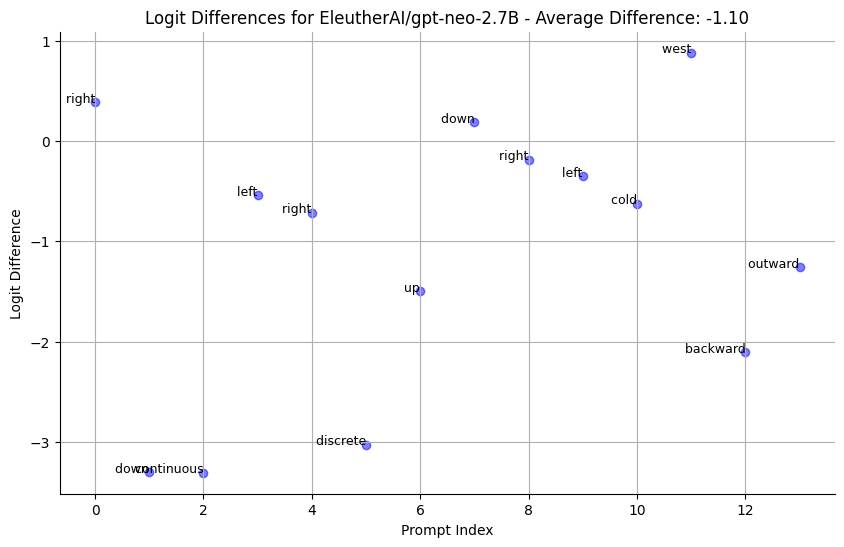

In [17]:
elided_cache = test_prompts_and_answers(elided_prompts_and_answers, model)

Prompt: Instead of turning left, the character turned                          Answer:  right          Logit Difference: 2.11
Prompt: The bird did not fly up, it flew                                       Answer:  down           Logit Difference: 1.75
Prompt: The data is not discrete, it is                                        Answer:  continuous     Logit Difference: 3.34
Prompt: She did not walk towards the right, she moved to the                   Answer:  left           Logit Difference: 2.63
Prompt: He did not walk towards the left, he moved to the                      Answer:  right          Logit Difference: 2.86
Prompt: The data is not continuous, it is                                      Answer:  discrete       Logit Difference: 3.27
Prompt: To avoid going down, the climber went                                  Answer:  up             Logit Difference: -0.43
Prompt: To avoid going up, the climber went                                    Answer:  down           Logit Differen

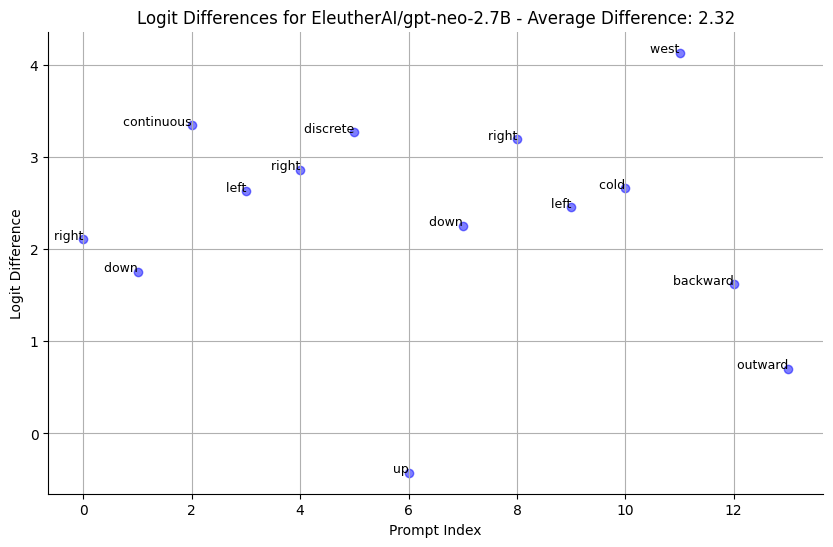

In [18]:
orig_cache = test_prompts_and_answers(prompts_and_answers, model)

## Direct Logit Attribution

*Look up unfamiliar terms in the [mech interp explainer](https://neelnanda.io/glossary)*

Further, the easiest part of the model to understand is the output - this is what the model is trained to optimize, and so it can always be directly interpreted! Often the right approach to reverse engineering a circuit is to start at the end, understand how the model produces the right answer, and to then work backwards. The main technique used to do this is called **direct logit attribution**

**Background:** The central object of a transformer is the **residual stream**. This is the sum of the outputs of each layer and of the original token and positional embedding. Importantly, this means that any linear function of the residual stream can be perfectly decomposed into the contribution of each layer of the transformer. Further, each attention layer's output can be broken down into the sum of the output of each head (See [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html) for details), and each MLP layer's output can be broken down into the sum of the output of each neuron (and a bias term for each layer).

The logits of a model are `logits=Unembed(LayerNorm(final_residual_stream))`. The Unembed is a linear map, and LayerNorm is approximately a linear map, so we can decompose the logits into the sum of the contributions of each component, and look at which components contribute the most to the logit of the correct token! This is called **direct logit attribution**. Here we look at the direct attribution to the logit difference!

<details> <summary>(*) <b>Background and motivation of the logit difference</b></summary>

Logit difference is actually a *really* nice and elegant metric and is a particularly nice aspect of the setup of Indirect Object Identification. In general, there are two natural ways to interpret the model's outputs: the output logits, or the output log probabilities (or probabilities).

The logits are much nicer and easier to understand, as noted above. However, the model is trained to optimize the cross-entropy loss (the average of log probability of the correct token). This means it does not directly optimize the logits, and indeed if the model adds an arbitrary constant to every logit, the log probabilities are unchanged.

But `log_probs == logits.log_softmax(dim=-1) == logits - logsumexp(logits)`, and so `log_probs(" Mary") - log_probs(" John") = logits(" Mary") - logits(" John")` - the ability to add an arbitrary constant cancels out!

Further, the metric helps us isolate the precise capability we care about - figuring out *which* name is the Indirect Object. There are many other components of the task - deciding whether to return an article (the) or pronoun (her) or name, realising that the sentence wants a person next at all, etc. By taking the logit difference we control for all of that.

Our metric is further refined, because each prompt is repeated twice, for each possible indirect object. This controls for irrelevant behaviour such as the model learning that John is a more frequent token than Mary (this actually happens! The final layernorm bias increases the John logit by 1 relative to the Mary logit)

</details>

<details> <summary>Ignoring LayerNorm</summary>

LayerNorm is an analogous normalization technique to BatchNorm (that's friendlier to massive parallelization) that transformers use. Every time a transformer layer reads information from the residual stream, it applies a LayerNorm to normalize the vector at each position (translating to set the mean to 0 and scaling to set the variance to 1) and then applying a learned vector of weights and biases to scale and translate the normalized vector. This is *almost* a linear map, apart from the scaling step, because that divides by the norm of the vector and the norm is not a linear function. (The `fold_ln` flag when loading a model factors out all the linear parts).

But if we fixed the scale factor, the LayerNorm would be fully linear. And the scale of the residual stream is a global property that's a function of *all* components of the stream, while in practice there is normally just a few directions relevant to any particular component, so in practice this is an acceptable approximation. So when doing direct logit attribution we use the `apply_ln` flag on the `cache` to apply the global layernorm scaling factor to each constant. See [my clean GPT-2 implementation](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/clean-transformer-demo/Clean_Transformer_Demo.ipynb#scrollTo=Clean_Transformer_Implementation) for more on LayerNorm.
</details>

Getting an output logit is equivalent to projecting onto a direction in the residual stream. We use `model.tokens_to_residual_directions` to map the answer tokens to that direction, and then convert this to a logit difference direction for each batch

To verify that this works, we can apply this to the final residual stream for our cached prompts (after applying LayerNorm scaling) and verify that we get the same answer.

<details> <summary>Technical details</summary>

`logits = Unembed(LayerNorm(final_residual_stream))`, so we technically need to account for the centering, and then learned translation and scaling of the layernorm, not just the variance 1 scaling.

The centering is accounted for with the preprocessing flag `center_writing_weights` which ensures that every weight matrix writing to the residual stream has mean zero.

The learned scaling is folded into the unembedding weights `model.unembed.W_U` via `W_U_fold = layer_norm.weights[:, None] * unembed.W_U`

The learned translation is folded to `model.unembed.b_U`, a bias added to the logits (note that GPT-2 is not trained with an existing `b_U`). This roughly represents unigram statistics. But we can ignore this because each prompt occurs twice with names in the opposite order, so this perfectly cancels out.

Note that rather than using layernorm scaling we could just study cache["ln_final.hook_normalised"]

</details>

In [30]:
orig_answer_residual_directions = model.tokens_to_residual_directions(
    get_answer_tokens([a[1] for a in prompts_and_answers], model=model, corrupted=False)
)
print("Answer residual directions shape:", orig_answer_residual_directions.shape)
orig_logit_diff_directions = (
    orig_answer_residual_directions[:, 0] - orig_answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", orig_logit_diff_directions.shape)

# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
orig_final_residual_stream = orig_cache["resid_post", -1]
print("Final residual stream shape:", orig_final_residual_stream.shape)
orig_final_token_residual_stream = orig_final_residual_stream[:, -1, :]
# Apply LayerNorm scaling
# pos_slice is the subset of the positions we take - here the final token of each prompt
orig_scaled_final_token_residual_stream = orig_cache.apply_ln_to_stack(
    orig_final_token_residual_stream, layer=-1, pos_slice=-1
)

orig_average_logit_diff = einsum(
    "batch d_model, batch d_model -> ",
    orig_scaled_final_token_residual_stream,
    orig_logit_diff_directions,
) / len(prompts)
print("Calculated average logit diff:", round(orig_average_logit_diff.item(), 3))
print("Original logit difference:", round(orig_average_logit_diff.item(), 3))



Answer residual directions shape: torch.Size([14, 2, 2560])
Logit difference directions shape: torch.Size([14, 2560])
Final residual stream shape: torch.Size([14, 15, 2560])
Calculated average logit diff: 2.384
Original logit difference: 2.384


In [31]:
elided_answer_residual_directions = model.tokens_to_residual_directions(
    get_answer_tokens(
        [a[1] for a in elided_prompts_and_answers], model=model, corrupted=False
    )
)
print("Answer residual directions shape:", elided_answer_residual_directions.shape)
elided_logit_diff_directions = (
    elided_answer_residual_directions[:, 0] - elided_answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", elided_logit_diff_directions.shape)

# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
elided_final_residual_stream = elided_cache["resid_post", -1]
print("Final residual stream shape:", elided_final_residual_stream.shape)
elided_final_token_residual_stream = elided_final_residual_stream[:, -1, :]
# Apply LayerNorm scaling
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = elided_cache.apply_ln_to_stack(
        elided_final_token_residual_stream, layer=-1, pos_slice=-1
)

elided_average_logit_diff = einsum(
    "batch d_model, batch d_model -> ",
    scaled_final_token_residual_stream,
    elided_logit_diff_directions,
) / len(prompts)
print("Calculated average logit diff:", round(elided_average_logit_diff.item(), 3))


Answer residual directions shape: torch.Size([14, 2, 2560])
Logit difference directions shape: torch.Size([14, 2560])
Final residual stream shape: torch.Size([14, 15, 2560])
Calculated average logit diff: -1.044


### Logit Lens

We can now decompose the residual stream! First we apply a technique called the [**logit lens**](https://www.alignmentforum.org/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) - this looks at the residual stream after each layer and calculates the logit difference from that. This simulates what happens if we delete all subsequence layers.

In [34]:
def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[torch.Tensor, "batch d_model"]
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=-1
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions,
    ) / len(prompts)

We see that the model gains its performance in the middle and later layers.

In [35]:
orig_accumulated_residual, labels = orig_cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
orig_logit_lens_logit_diffs = residual_stack_to_logit_diff(orig_accumulated_residual, orig_cache, orig_logit_diff_directions)
line(
    orig_logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    title="Original Logit Difference From Accumulated Residual Stream",
)

Similar behavior in elided prompts, but in the opposite direction. The model only gets worse in later layers. 

In [36]:
elided_accumulated_residual, labels = elided_cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
elided_logit_lens_logit_diffs = residual_stack_to_logit_diff(
    elided_accumulated_residual, elided_cache, elided_logit_diff_directions
)
line(
    elided_logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    title="Elided Logit Difference From Accumulated Residual Stream",
)

### Layer Attribution

Observe that most of the logit diffs are in the attention layers. This suggests that attending to words like 'instead' and moving that info is big. Whereas after eliding the prompts, the logit diffs are all over the place, and much weaker. My intuition is that once those key words are gone, info is diffused and the model can't just attend to find an answer. This suggests that the hypothesis 



In [37]:
orig_per_layer_residual, labels = orig_cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)
orig_per_layer_logit_diffs = residual_stack_to_logit_diff(
    orig_per_layer_residual, orig_cache, orig_logit_diff_directions
)
line(
    orig_per_layer_logit_diffs,
    hover_name=labels,
    title="Logit Difference From Each Layer for Original Prompts",
)

In [38]:
elided_per_layer_residual, labels = elided_cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)
elided_per_layer_logit_diffs = residual_stack_to_logit_diff(
    elided_per_layer_residual, elided_cache, elided_logit_diff_directions
)
line(
    elided_per_layer_logit_diffs,
    hover_name=labels,
    title="Logit Difference From Each Layer for Elided Prompts",
)



## Head Attribution

We can further break down the output of each attention layer into the sum of the outputs of each attention head. Each attention layer consists of 12 heads, which each act independently and additively.

<details> <summary>Decomposing attention output into sums of heads</summary>
The standard way to compute the output of an attention layer is by concatenating the mixed values of each head, and multiplying by a big output weight matrix. But as described in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) this is equivalent to splitting the output weight matrix into a per-head output (here `model.blocks[k].attn.W_O`) and adding them up (including an overall bias term for the entire layer)
</details>

We see that only a few heads really matter - heads L9H6 and L9H9 contribute a lot positively (explaining why attention layer 9 is so important), while heads L10H7 and L11H10 contribute a lot negatively (explaining why attention layer 10 and layer 11 are actively harmful). These correspond to (some of) the name movers and negative name movers discussed in the paper. There are also several heads that matter positively or negatively but less strongly (other name movers and backup name movers)

There are a few meta observations worth making here - our model has 144 heads, yet we could localise this behaviour to a handful of specific heads, using straightforward, general techniques. This supports the claim in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) that attention heads are the right level of abstraction to understand attention. It also really surprising that there are *negative* heads - eg L10H7 makes the incorrect logit 7x *more* likely. I'm not sure what's going on there, though the paper discusses some possibilities.

In [39]:
orig_per_head_residual, labels = orig_cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
orig_per_head_logit_diffs = residual_stack_to_logit_diff(
    orig_per_head_residual, orig_cache, orig_logit_diff_directions
)
orig_per_head_logit_diffs = einops.rearrange(
    orig_per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    orig_per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head for Original Prompts",
)

Tried to stack head results when they weren't cached. Computing head results now


In [40]:
elided_per_head_residual, labels = elided_cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
elided_per_head_logit_diffs = residual_stack_to_logit_diff(
    elided_per_head_residual, elided_cache, elided_logit_diff_directions
)
elided_per_head_logit_diffs = einops.rearrange(
    elided_per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    elided_per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head for Elided Prompts",
)

Tried to stack head results when they weren't cached. Computing head results now


## Attention Analysis

Attention heads are particularly easy to study because we can look directly at their attention patterns and study from what positions they move information from and two. This is particularly easy here as we're looking at the direct effect on the logits so we need only look at the attention patterns from the final token.

We use Alan Cooney's circuitsvis library to visualize the attention patterns! We visualize the top 3 positive and negative heads by direct logit attribution, and show these for the first prompt (as an illustration).

<details> <summary>Interpreting Attention Patterns</summary>
An easy mistake to make when looking at attention patterns is thinking that they must convey information about the <i>token</i> looked at (maybe accounting for the context of the token). But actually, all we can confidently say is that it moves information from the *residual stream position* corresponding to that input token. Especially later on in the model, there may be components in the residual stream that are nothing to do with the input token! Eg the period at the end of a sentence may contain summary information for that sentence, and the head may solely move that, rather than caring about whether it ends in ".", "!" or "?"
</details>

In [41]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

Similar to expectation that the 'opposition words' will be highly-attended to, and eliding them spreads attention everywhere.


In [42]:
top_k = 3
orig_prompts, orig_answers = unzip(prompts_and_answers)
orig_tokens = model.to_tokens(leftpad(prompts, model), prepend_bos=True)
top_positive_logit_attr_heads = torch.topk(
    orig_per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    orig_cache,
    orig_tokens[0],
    f"Top {top_k} Positive Logit Attribution Heads for Original Prompts",
)

top_negative_logit_attr_heads = torch.topk(
    -orig_per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    orig_cache,
    orig_tokens[0],
    title=f"Top {top_k} Negative Logit Attribution Heads for Original Prompts",
)

HTML(positive_html + negative_html)

In [43]:
top_k = 3
elided_prompts, elided_answers = unzip(elided_prompts_and_answers)
elided_tokens = model.to_tokens(leftpad(elided_prompts, model), prepend_bos=True)
top_positive_logit_attr_heads = torch.topk(
    elided_per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    elided_cache,
    elided_tokens[0],
    f"Top {top_k} Positive Logit Attribution Heads for Elided Prompts",
)

top_negative_logit_attr_heads = torch.topk(
    -elided_per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    elided_cache,
    elided_tokens[0],
    title=f"Top {top_k} Negative Logit Attribution Heads for Elided Prompts",
)

HTML(positive_html + negative_html)